In [12]:
import sys
from typing import List
import numpy as np
import tables
import matplotlib.pyplot as plt
from phd.satellite.mean_table import Normilizer
# from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

In [2]:
from scipy.stats import norm
path = "/home/zelenyy/data/satellite/MCMC_1_69/mcmc_1_69.hdf5"

In [8]:
with tables.open_file(path) as h5file:
    table = h5file.get_node("/sim2100/deposit")
    print(repr(table.attrs))
    data = table.read()
    

/sim2100/deposit._v_attrs (AttributeSet), 21 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0.0,
    FIELD_0_NAME := 'event',
    NROWS := 10000,
    TITLE := 'Deposit in detector cell',
    VERSION := '2.7',
    path := 'sim2100',
    text := '/df/project test\n/df/gdml ../../satellite.gdml\n/satellite/output file\n/satellite/detector single\n\n/gps/particle proton\n/gps/number 1\n/gps/direction -0.49999999999999994 0.0 -0.8660254037844387\n/gps/ene/mono 30.0 MeV\n/gps/position 0.07499999999999998 0. 0.22990381056766582 m\n/run/beamOn 10000\n',
    values_macros_dirX := -0.49999999999999994,
    values_macros_dirZ := -0.8660254037844387,
    values_macros_energy := 30.0,
    values_macros_mode := 'single',
    values_macros_number := 10000,
    values_macros_particle := 'proton',
    values_macros_posX := 0.07499999999999998,
    values_macros_posZ := 0.22990381056766582,
    values_macros_radius := 0.15,
    values_macros_shift := 0,
    values_macros_theta := 30.0,
    values

In [9]:
data.dtype

dtype([('event', '<f4', (100,))])

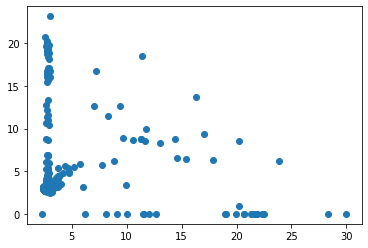

In [10]:
plt.scatter(data["event"][:, 0], data["event"][:,1])

In [11]:
np.all(data[0]==0.0)


/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  """Entry point for launching an IPython kernel.


False

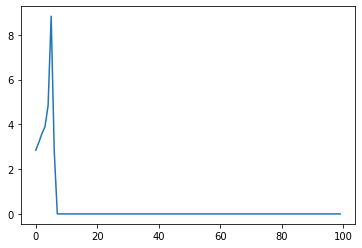

In [12]:
plt.plot(data["event"][0])

In [77]:
# path = "/mnt/storage2/phd/data/satellite/Anthracene/mean_anthracene.hdf5"




In [2]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/proton.hdf5"
with tables.open_file(path) as h5file:
    data = h5file.get_node("/", "deposit").read()

In [3]:
points = np.zeros(shape=(data.size, 3))
points[:, 0] = data["energy"][:]
points[:, 1] = data["theta"][:]
points[:, 2] = data["shift"][:]
for i in range(3):
    temp = points[:, i]
    min_ = temp.min()
    max_ = temp.max()
    points[:, i] = (temp - min_)/(max_ - min_)

In [4]:
path = "/mnt/storage2/phd/data/satellite/polistyrene/mean_mesh.hdf5"
with tables.open_file(path) as h5file:
    mean = h5file.get_node("/proton", "mean").read()
    var = h5file.get_node("/proton", "variance").read()
    energy_node = h5file.get_node("/proton", "energy")
    energy = energy_node.read()
    energy_normilizer = Normilizer(energy_node.attrs["init"], step=energy_node.attrs["step"], norm=energy_node.attrs["norm"])
    theta = h5file.get_node("/proton", "theta").read()
    shift = h5file.get_node("/proton", "shift").read()

In [215]:
# path = "/mnt/storage2/phd/data/satellite/polistyrene/mean_mesh.hdf5"
# with tables.open_file(path) as h5file:
#     energy_node = h5file.get_node("/proton", "energy")
#     energy = energy_node.read()
#     energy_normilizer = Normilizer(energy_node.attrs["init"], step=energy_node.attrs["step"], norm=energy_node.attrs["norm"])


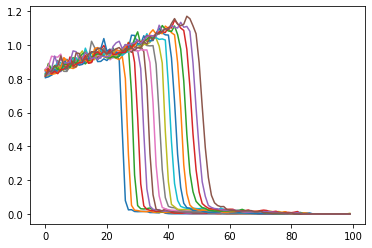

In [36]:
for i in range(16):
    plt.plot(mean[:, 100, 30, i])

In [29]:
ranges = data["mean"][:].argmin(axis=1)

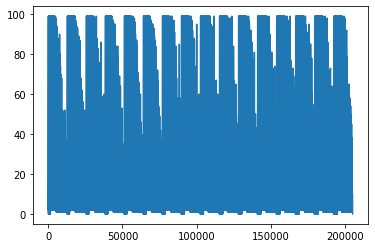

In [31]:
ranges.shape
plt.plot(ranges)

In [33]:
print(ranges[:10])

[2 2 2 2 3 3 3 4 4 4]


In [49]:
indx_ranges = ranges != 0.0

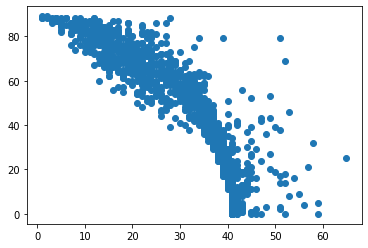

In [51]:
indx = np.logical_and(data["energy"] == 70.0, indx_ranges)
plt.scatter(ranges[indx], data["theta"][indx])

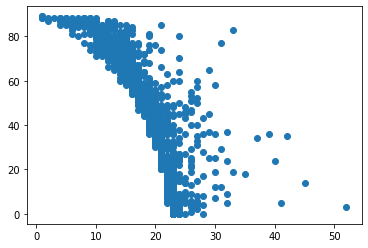

In [52]:
indx = np.logical_and(data["energy"] == 50.0, indx_ranges)
plt.scatter(ranges[indx], data["theta"][indx])

In [28]:
indx_empty = (mean[0] == 0)
ranges_mesh = (mean != 0.0).argmin(axis=0)
indx = np.logical_and(ranges_mesh == 0, np.logical_not(indx_empty))
ranges_mesh[indx] = 100

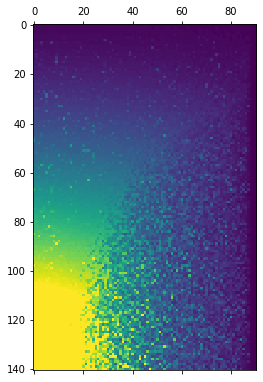

In [29]:
plt.matshow(ranges_mesh[:,:,0])


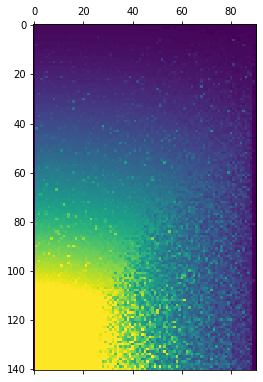

In [33]:
plt.matshow(ranges_mesh[:,:,-1])

In [67]:
print(ranges_mesh.shape)
print(ranges_mesh[:, 0, 0])

(141, 91, 16)
[  2   2   2   2   3   3   3   4   4   4   5   5   6   6   6   7   7  11
   8   9   9  10  10  11  12  12  13  13  14  15  19  16  17  17  18  19
  22  21  21  22  24  25  26  25  26  27  38  50  30  31  31  32  34  34
  35  36  37  39  39  40  47  43  43  50  47  48  49  65  51  51  53  53
  55  56  57  65  59  63  62  68  64  68  67  68  71  86  72  76  75  76
  80  79  81  82  84  89  86  87 100  90  92  93  94  96  97 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100]


In [68]:
# def theta_constrain(ranges_mesh, energy_indx, theta):
energy_indx = 50
range_mesh = ranges_mesh[energy_indx]
min_range = range_mesh.min(axis=1)
print(min_range.shape)

(91,)


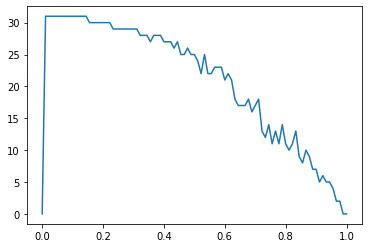

In [75]:
plt.plot(theta, min_range)
    

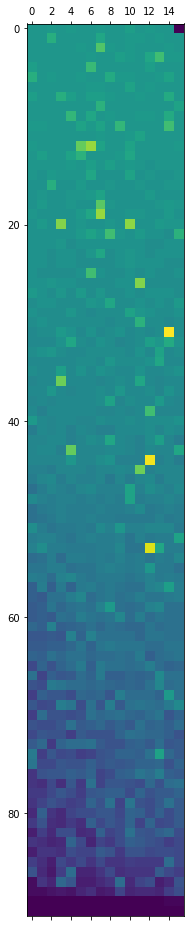

In [71]:
plt.matshow(range_mesh)


In [9]:
event = data["mean"][70]
range_max = event.argmin()
full_energy = energy_normilizer.normalize(np.sum(event))
bounds = ((full_energy, 1.0), (0.0, 1.0), (0.0, 1.0))

In [10]:
print(full_energy)

0.4897725664338187


In [13]:
x0 = np.array([full_energy + 0.1, 0.5, 0.5])
result = minimize(likelyhood, x0, method="Nelder-Mead", options={'adaptive': True})
result

 final_simplex: (array([[0.61926119, 0.5       , 0.5       ],
       [0.61917456, 0.50001505, 0.49997294],
       [0.6192002 , 0.50002763, 0.50001775],
       [0.61923756, 0.49996031, 0.50001243]]), array([0., 0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 82
           nit: 22
        status: 0
       success: True
             x: array([0.61926119, 0.5       , 0.5       ])

In [14]:
x0 = np.array([0.6, 0.1, 0.1])
result = minimize(likelyhood, x0)
result

      fun: 0.006294261116130873
 hess_inv: array([[ 1.47422435e-01, -6.20768348e-03, -9.48316689e-03],
       [-6.20768348e-03,  2.62732822e-03, -3.95942449e-04],
       [-9.48316689e-03, -3.95942449e-04,  9.99931690e-01]])
      jac: array([-0.00893398,  0.02024822, -0.0004343 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 462
      nit: 3
     njev: 90
   status: 2
  success: False
        x: array([0.91493055, 0.09565338, 0.10037614])

In [15]:
bounds = ((full_energy, 1.0), (0.0, 1.0), (0.0, 1.0))
x0 = np.array([0.7, 0.1, 0.1])
result = minimize(likelyhood, x0, method="L-BFGS-B", bounds=bounds)
print(result)

      fun: 0.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([0.48977257, 0.56087747, 0.96909685])


In [225]:
indx = points[:, 2] == 0.0

In [226]:
temp_xy = points[indx]

In [227]:
temp_z = likelyhood.calculate_many(temp_xy)



In [228]:
temp_z_mat = temp_z.reshape((energy.size, theta.size))


In [192]:
indx = temp_z_mat > -1000
print(indx.sum())
# temp_z_mat[indx] = -1000
# plt.matshow(temp_z_mat)
# 
# plt.colorbar()

1471


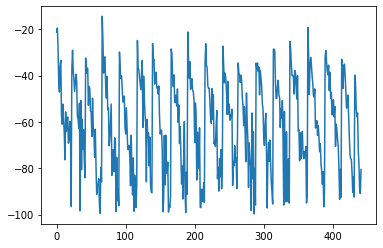

In [222]:
plt.plot(temp_z[temp_z>-100])


Text(0.5, 0, 'energy')

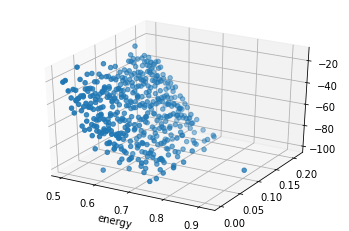

In [229]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indx = temp_z > -100
xs = temp_xy[indx, 0]
ys = temp_xy[indx, 1]
ax.scatter(xs, ys, temp_z[indx])
ax.set_xlabel("energy")

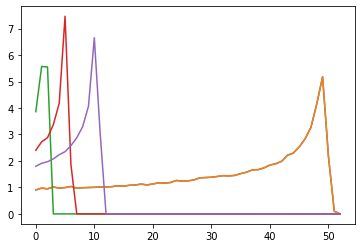

In [209]:
plt.plot(likelyhood.event)
plt.plot(likelyhood.last_mean[:, 70])
plt.plot(likelyhood.last_mean[:, 710])
plt.plot(likelyhood.last_mean[:, 720])
plt.plot(likelyhood.last_mean[:, 730])

In [230]:
index_lh = np.where(temp_z > -100)[0]

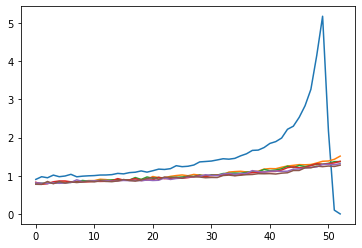

In [231]:
plt.plot(likelyhood.event)
for i in index_lh[15:20]:
    plt.plot(likelyhood.last_mean[:, i])


In [234]:
plt.hlines(points[70, 0])
plt.plot(points[index_lh, 0])

TypeError: hlines() missing 2 required positional arguments: 'xmin' and 'xmax'